<a href="https://colab.research.google.com/github/huyhoang1996vn/ai_application/blob/main/ai_for_dev_B4_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install flask pyngrok
!pip install flask-cors

In [15]:
from pyngrok import ngrok
from google.colab import userdata

# Replace 'YOUR_NGROK_AUTHTOKEN' with the authtoken you copied from the ngrok dashboard
# authtoken = userdata.get("ngrok_key")
ngrok.set_auth_token("22zlLHLbISCvPpwt4ydRGtNfCPv_4cmib543NDet2vQZxeSQV")


In [4]:
!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

--2025-05-01 11:49:34--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.25, 13.226.210.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 897952466 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_large.pt’

sam2_hiera_large.pt 100%[===================>] 856.35M   179MB/s    in 8.3s    

2025-05-01 11:49:43 (104 MB/s) - ‘sam2_hiera_large.pt’ saved [897952466/897952466]



In [5]:
!git clone https://github.com/facebookresearch/segment-anything-2.git

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [6]:
%cd /content/segment-anything-2
!pip install -e .

/content/segment-anything-2
Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00

In [10]:
from PIL import Image
import numpy as np
image = Image.open('/content/truck.jpg')
image = np.array(image.convert("RGB"))

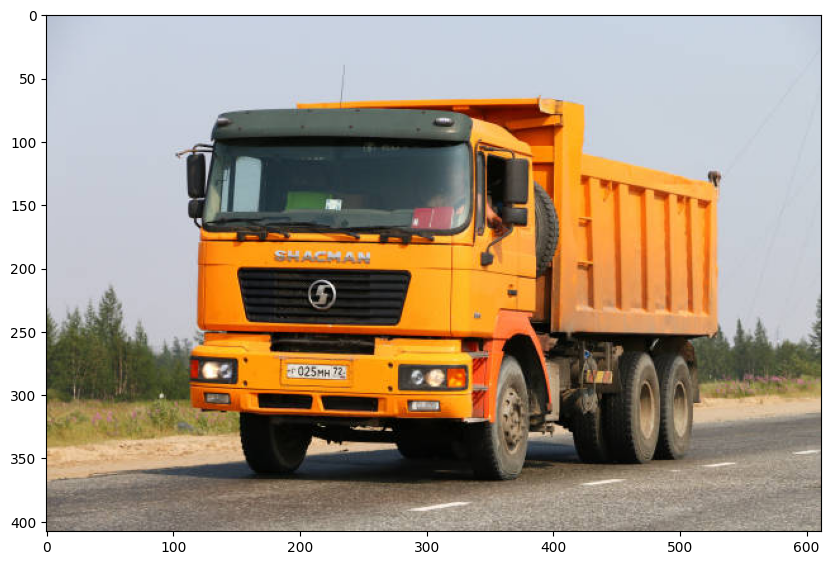

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [4]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0,0,1,0.4), thickness=1)

    ax.imshow(img)

In [14]:
import os

print(os.getcwd())

/content


In [6]:
import os

config_file_path = "./segment-anything-2/sam2/configs/sam2/sam2_hiera_s.yaml"

if os.path.exists(config_file_path):
  print(f"The file exists at: {config_file_path}")
else:
  print(f"The file was not found at: {config_file_path}")

The file exists at: ./segment-anything-2/sam2/configs/sam2/sam2_hiera_s.yaml


In [7]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator


import hydra
from sam2.build_sam import build_sam2

# hydra is initialized on import of sam2, which sets the search path which can't be modified
# so we need to clear the hydra instance
hydra.core.global_hydra.GlobalHydra.instance().clear()

# set the search path manually
search_path = os.path.abspath("./segment-anything-2/sam2/configs")
hydra.initialize_config_dir(config_dir=search_path, version_base=None)

# Now build_sam2 should find the config file
sam2_checkpoint = "./sam2_hiera_large.pt"
model_cfg = "sam2/sam2_hiera_l" # Specify the config file name without the extension


sam2 = build_sam2(model_cfg, sam2_checkpoint, device ='cuda', apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [8]:
masks = mask_generator.generate(image)

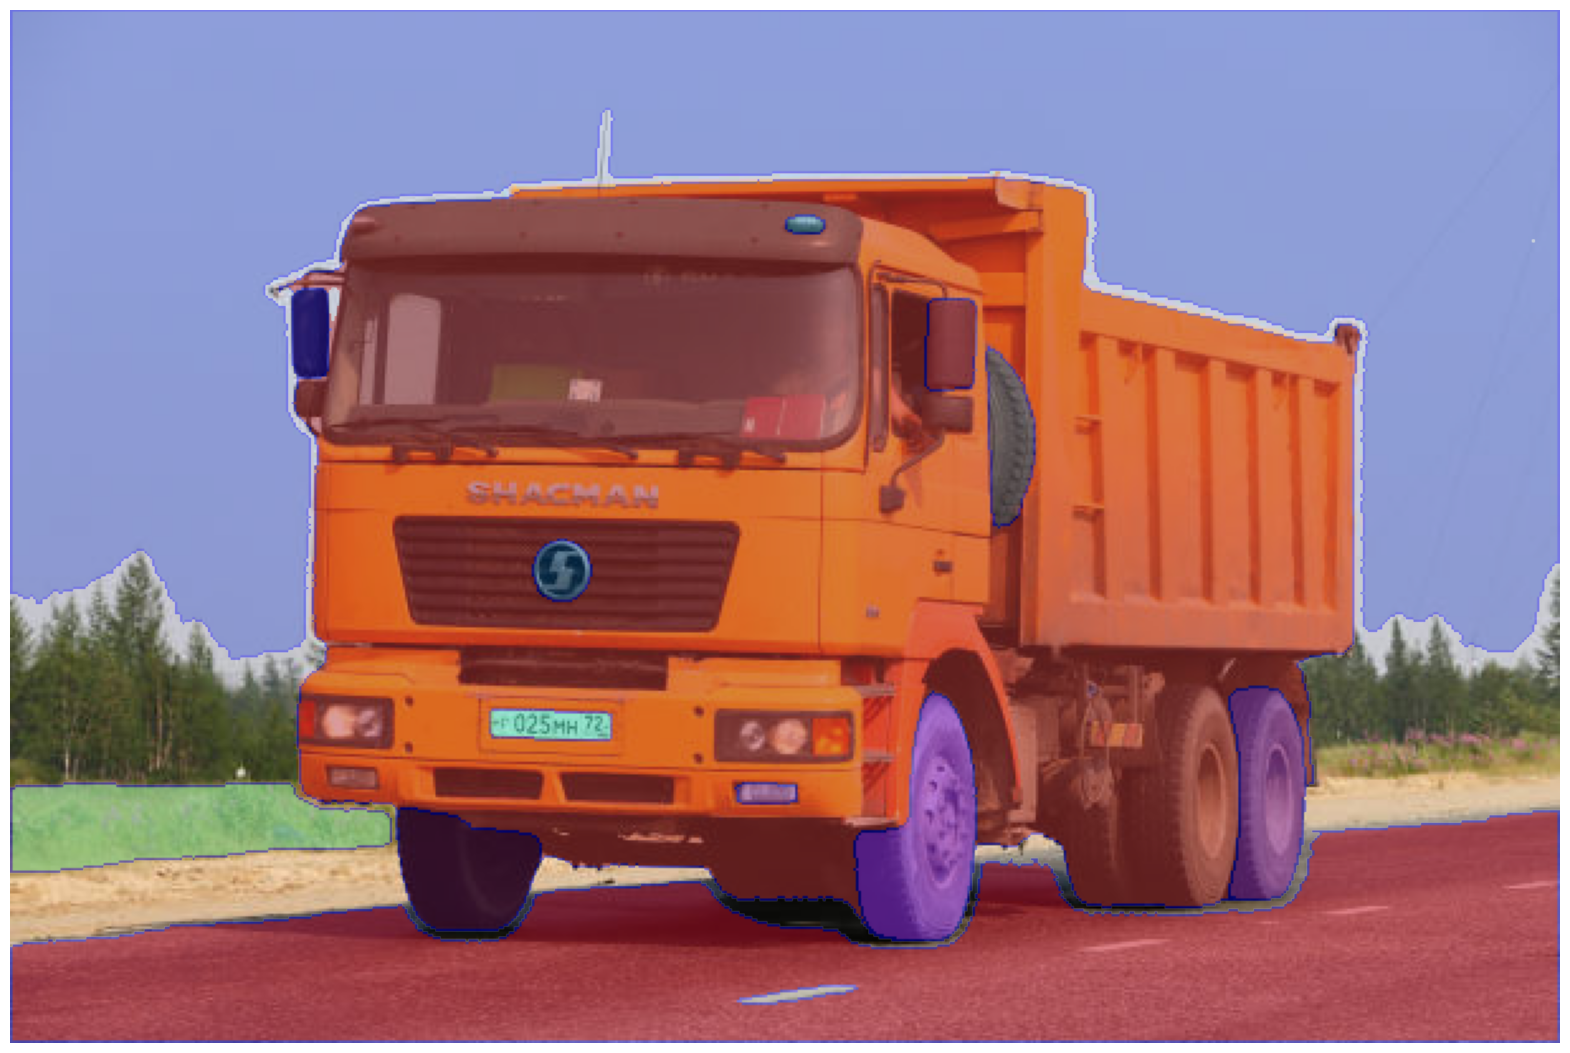

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [13]:
import numpy as np
import multiprocessing as mp
import time

def convert_chunk(chunk):
    return chunk.tolist()

def array_to_list_in_parallel(array, num_processes):
    # Determine the size of each chunk
    chunk_size = array.shape[0] // num_processes

    # Create chunks of the array
    chunks = [array[i*chunk_size:(i+1)*chunk_size] for i in range(num_processes)]

    # Use multiprocessing to convert each chunk to a list
    with mp.Pool(num_processes) as pool:
        result = pool.map(convert_chunk, chunks)

    # Combine the results into a single list
    list_representation = []
    for chunk_list in result:
        list_representation.extend(chunk_list)

    return list_representation

In [ ]:
from flask import Flask, request, jsonify
from pyngrok import ngrok
from flask_cors import CORS
import cv2
import json

app = Flask(__name__)
CORS(app)  # Enable CORS

# Initialize your SAM generator (assuming it's done like this)
mask_generator = SAM2AutomaticMaskGenerator(sam2)
# from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

# Initialize Flask app
app = Flask(__name__)

# Load SAM model
# sam = sam_model_registry["default"](checkpoint="sam_vit_h.pth")
# sam.eval()
# generator = SamAutomaticMaskGenerator(sam)


# Test endpoint
@app.route('/')
def home():
    return "Hello, World!"

# SAM mask endpoint
@app.route('/sam', methods=['POST'])
def sam_endpoint():
    # Get the image from the client
    file = request.files['image']
    image = cv2.imdecode(np.frombuffer(file.read(), np.uint8), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Generate masks
    masks = mask_generator.generate(image)
    masks = sorted(masks, key=lambda x: x['area'], reverse=True)[:4]

    # Convert masks to a serializable format
    new_masks = []
    for item in masks:
        new_masks.append({
            "segmentation": array_to_list_in_parallel(item["segmentation"], mp.cpu_count()),
        })
    json_data = json.dumps(new_masks)

    return jsonify(json_data)

# Terminate any open tunnels if running in a reused environment
ngrok.kill()

# Create a tunnel to the default Flask port 5000
public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")

if __name__ == '__main__':
    app.run()

Public URL: NgrokTunnel: "https://65be-34-125-23-174.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [01/May/2025 12:19:44] "POST /sam HTTP/1.1" 200 -
